# Exploration done on the EPFL recommender system

In [12]:
from IPython.core.display import display, HTML
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split
import configparser
import mysql.connector as sql
import pandas as pd
import numpy as np
%config InlineBackend.figure_format = 'retina'

# Read the confidential token.
credentials = configparser.ConfigParser()
credentials.read('credentials.ini')
db_connection = sql.connect(host=credentials.get('mysql', 'url'),
                            database='semester_project_romain',
                            user=credentials.get('mysql', 'username'),
                            password=credentials.get('mysql', 'password'))

In [13]:
# Found courses that should be removed:
courses_to_remove = [
    "Admission année sup.",
    "Projet de master en systèmes de communication",
    "SHS : Introduction au projet",
    "Cycle master",
    "Projet de Master",
    "Groupe Core courses & options",
    "Bloc Projets et SHS",
    "Groupe 2 : Options",
    "Master SC",
    "Mineur",
    "Groupe 1",
    "Projet en systèmes de communication II",
    "Projet en informatique II",
    "Projet de master en informatique",
    "Cours réservés spécifiquement aux étudiants s'inscrivant pour le mineur Area and Cultural Studies",
    "SHS : Projet",
    "Optional project in communication systems",
    "Optional project in computer science",
    "Mineur : Neurosciences computationnelles",
    "Stage d'ingénieur crédité avec le PDM (master en Systèmes de communication)",
    "Cours UNIL - Faculté des hautes études commerciales HEC I (printemps)",
]

domains_to_remove = [
    "Humanities and social sciences",
    "Programme Sciences humaines et sociales",
]

In [ ]:
# PlanType = "PLAN_EXAMINE" ?????
all_info = """
            select distinct 
                PersonID, 
                PedagogicalCode, 
                StudyDomain, 
                UnitName, 
                UnitID,
                SubjectName, 
                SubjectID,
                SectionName, 
                YearName,
                CourseCode
            from 
                course_enrolments_with_info 
            where 
                LevelName = "Master"
                and (YearName = "2010-2011"
                or YearName = "2011-2012"
                or YearName = "2012-2013"
                or YearName = "2013-2014"
                or YearName = "2014-2015"
                or YearName = "2015-2016")
            """
all_df = pd.read_sql(all_info, con=db_connection)
all_df = all_df[~all_df.SubjectName.isin(courses_to_remove)]
# Removing the SHS courses
all_df = all_df[~(all_df.StudyDomain.isin(domains_to_remove))]
print(all_df.UnitName.unique())
all_df

In [14]:
# PlanType = "PLAN_EXAMINE" ?????
all_info = """
            select distinct 
                PersonID, 
                PedagogicalCode, 
                StudyDomain, 
                UnitName, 
                SubjectName, 
                Course_Enrolments.SubjectID,
                SectionName, 
                CourseCode,
                YearName
            from 
                Course_Enrolments
                inner join 
                Course_Codes 
                    on Course_Codes.planid = course_enrolments.planid 
                    and Course_Codes.subjectid = course_enrolments.subjectid
            where 
                UnitName like "%nform%" 
                and LevelName = "Master"
                and IsStudent = 1
                and (YearName = "2010-2011"
                or YearName = "2011-2012"
                or YearName = "2012-2013"
                or YearName = "2013-2014"
                or YearName = "2014-2015"
                or YearName = "2015-2016")
            """
all_df = pd.read_sql(all_info, con=db_connection)
all_df = all_df[~all_df.SubjectName.isin(courses_to_remove)]
# Removing the SHS courses
all_df = all_df[~(all_df.StudyDomain.isin(domains_to_remove))]
all_df

,PersonID,PedagogicalCode,StudyDomain,UnitName,SubjectName,SubjectID,SectionName,CourseCode,YearName
0,127608672,MA1,Life sciences,Informatique,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2012-2013
1,876419889,MA1,Life sciences,Informatique,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2012-2013
2,903788263,MA1,Life sciences,Informatique,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2012-2013
3,900069133,MA1,Life sciences,Informatique,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2012-2013
4,1151607670,MA1,Life sciences,Informatique,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2012-2013
5,910862692,MA1,Life sciences,Informatique,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2012-2013
6,1582764441,MA1,Life sciences,Informatique,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2012-2013
7,910941871,MA1,Life sciences,Informatique,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2012-2013
8,909087663,MA1,Life sciences,Informatique,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2012-2013
9,120566031,MA1,Life sciences,Informatique,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2012-2013


In [ ]:
current_courses = """
            select distinct 
                PedagogicalCode, 
                SubjectName, 
                SubjectID,
                StudyDomain,
                YearName
            from 
                course_enrolments_with_info 
            where 
                UnitName like "%ommunication%" 
                and 
                LevelName = "Master"
                and left(PedagogicalCode, 2) = "MA"
                and YearName = "2015-2016"
            """
current_courses_df = pd.read_sql(current_courses, con=db_connection)
# These are the current courses (latest data) given in syscom @EPFL
current_courses_df = current_courses_df[~current_courses_df.SubjectName.isin(courses_to_remove)]
current_courses_df = current_courses_df[~current_courses_df.StudyDomain.isin(domains_to_remove)]
current_courses_df

### Most taken courses
We need to find a way to get a cleaner dataset of courses, a lot of them are not usefull or outdated and should not be recommended.

In [15]:
# Taking a look at the most taken courses
registrations_df = all_df.set_index(['SubjectName', 'YearName'])
all_df_registrations = registrations_df.groupby(['SubjectName', 'YearName']).size()

registrations_df['Registration'] = all_df_registrations
registrations_df = registrations_df.reset_index()
# Pick only courses that have a study domain (removes bullshit)
# such as Projects and groups, minors etc
registrations_df = registrations_df[~registrations_df.StudyDomain.isnull()]
# Remove the SHS courses
registrations_df = registrations_df[~(registrations_df.StudyDomain == "Programme Sciences humaines et sociales")]
# Removes non important information
registrations_df = registrations_df.drop([
    'PersonID', "StudyDomain", "SectionName", "PedagogicalCode",
    "CourseCode"], axis=1)
registrations_df = registrations_df.drop_duplicates()
registrations_df = registrations_df.set_index(['SubjectName', 'YearName']).sort_index()
registrations = registrations_df.sort_values(ascending=False, by='Registration')

# Latest data registrations
registrations.xs('2015-2016', level='YearName')

,UnitName,SubjectID,Registration
SubjectName,,,
Distributed algorithms,Informatique,1773287,124
Pattern classification and machine learning,Informatique,1771468,124
Foundations of software,Informatique,71840397,107
TCP/IP networking,Informatique,1771764,105
Intelligent agents,Informatique,1771183,105
Cryptography and security,Informatique,1770973,98
Concurrent algorithms,Informatique,231901032,90
Unsupervised and reinforcement learning in neural networks,Informatique,1771794,69
Advanced computer graphics,Informatique,1770923,66


### Creating the binary matrix

In [16]:
courses_matrix = all_df[['PersonID', 'SubjectName']]
courses_matrix = courses_matrix.drop_duplicates()
courses_matrix = courses_matrix.set_index(['PersonID', 'SubjectName'])

def series_to_integers(series):
    "Converts a whole series to integers"
    return pd.to_numeric(series, downcast='integer')

# If the course was taken, set it to 1
courses_matrix['joined'] = 1
courses_matrix = courses_matrix.reset_index().pivot(index='PersonID', columns='SubjectName', values='joined')
courses_matrix = courses_matrix.fillna(0)
courses_matrix = courses_matrix.apply(series_to_integers)
courses_matrix

SubjectName,Accounting for finance,Advanced algorithms,Advanced analysis I,Advanced analysis II,Advanced compiler construction,Advanced computer architecture,Advanced computer graphics,Advanced computer networks and distributed systems,Advanced cryptography,Advanced databases,...,Time series,Topics in theoretical computer science,Traitement quantique de l'information,Traitement quantique de l'information I,Traitement quantique de l'information II,Unsupervised and reinforcement learning in neural networks,VLSI design I,VLSI design I + EDA TP,VLSI design II,Virtual reality
PersonID,,,,,,,,,,,,,,,,,,,,,
2412404,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2414145,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2436004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2501514,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2501538,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2505593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2523797,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4154961,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4155186,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Splitting test/train

In [ ]:
# Total matrix, use it to split train and test
registrations_total = courses_matrix.unstack().reset_index()
registrations_total = registrations_total.rename(columns={0: "Taken"})
#test_set = registrations_total.sample(frac=0.2, replace=False)
#train_set = registrations_total - test_set
train, test = train_test_split(registrations_total, test_size=0.2)
print("We have {} rows in total".format(len(registrations_total)))
print("Train: {} rows".format(len(train)))
print("Test: {} rows".format(len(test)))

In [ ]:
# Back to training matrix
courses_matrix = train.pivot(index='PersonID', columns='SubjectName', values="Taken")
courses_matrix = courses_matrix.fillna(0)
courses_matrix = courses_matrix.apply(series_to_integers)
courses_matrix

### Collaborative filtering through correlation matrix
We use the Jaccard score to compute the similarity matrix and then apply on the binary matrix to predict good courses to take. 

#### Collaborative filtering with Jaccard similarity

In [ ]:
from scipy.stats import entropy
from numpy.linalg import norm
import numpy as np

def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

# Using the Jensen-Shannon similarity
corr_courses_matrix = pd.DataFrame(np.zeros((courses_matrix.T.shape[0], courses_matrix.T.shape[0])))
for i in range(courses_matrix.T.shape[0]):
    print("Computing similarity: {:.2f}%".format(100*i/courses_matrix.T.shape[0]), end="\r")
    for j in range(courses_matrix.T.shape[0]):
        corr_courses_matrix.iloc[i].iloc[j] = JSD(courses_matrix.T.iloc[i], courses_matrix.T.iloc[j])
        
corr_courses_matrix = 1 - corr_courses_matrix.replace([np.inf, -np.inf], 1)

print(corr_courses_matrix.shape)
print(corr_courses_matrix)

# Using Jaccard distance
#corr_courses_matrix = squareform(1 - pdist(courses_matrix.T, 'jaccard'))

# Using Pearson correlation
#corr_courses_matrix = np.corrcoef(courses_matrix.T)  

#corr_courses_matrix = squareform(pdist(courses_matrix.T, lambda x: JSD))

In [ ]:
course_index = courses_matrix.columns

def get_course_similarity(course):  
    '''Returns correlation vector for a course'''
    course_idx = list(course_index).index(course)
    return corr_courses_matrix[course_idx]

def get_course_recommendations(user_courses):  
    '''Given a set of courses, it returns all the courses with their similarity score'''
    course_similarities = np.zeros(corr_courses_matrix.shape[0])
    for course_id in user_courses:
        course_similarities = course_similarities + get_course_similarity(course_id)
    similarities_df = pd.DataFrame({
        'course_title': course_index,
        'sum_similarity': course_similarities
        })
    similarities_df = similarities_df[similarities_df.course_title.isin(user_courses)]
    similarities_df = similarities_df.sort_values(by=['sum_similarity'], ascending=False)
    return similarities_df

def recommend_row(user_row):
    sample_user = 1801481982
    sample_user_courses = list(user_row.sort_values(ascending=False).index)
    recommendations = get_course_recommendations(sample_user_courses)
    
# Le'ts try it out for a random user
#sample_user = 1801481982
sample_user = 1892490156
sample_user_courses = list(courses_matrix.loc[sample_user].sort_values(ascending=False).index)
recommendations = get_course_recommendations(sample_user_courses)

row = courses_matrix.loc[sample_user]
user_courses_as_list = list(row[row > 0].index)
# We get the top 20 recommended courses
print("The user {} has the following courses: \n- {}\
      \nso we recommend him to pick:"
      .format(sample_user,
              "\n- ".join(user_courses_as_list)))
# Only accept recommendations from latest data courses (2015-2016)
accepted_recommendations = recommendations[recommendations.course_title.isin(current_courses_df.SubjectName)]
# Removing bloat courses and courses that the user took
accepted_recommendations = accepted_recommendations.dropna()
accepted_recommendations = accepted_recommendations[~accepted_recommendations.course_title.isin(user_courses_as_list)]

# Normalizing the results by dividing by the maximum of the summed similarities
accepted_recommendations.sum_similarity = accepted_recommendations.sum_similarity / accepted_recommendations.sum_similarity.max()
accepted_recommendations

# Code used to predict one course:
#favoured_course = 'Distributed information systems'
#favoured_course_index = list(courses_index).index(favoured_course)
#P = corr_courses_matrix[favoured_course_index]

# list the courses with a high correlation with the favoured course
#print(list(courses_index[(P>0.3) & (P<1.0)])  

#### Collaborative filtering with KNN

In [ ]:
# Trying Surprise with KNN
from collections import defaultdict
from surprise.dataset import Reader
from surprise import SVD, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, Dataset, evaluate, print_perf, accuracy

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def k_fold(data, algorithm):
    errors = []
    for trainset, testset in data.folds():
        # shut up while doing it
        from IPython.utils import io
        with io.capture_output() as captured:
            # train and test algorithm.
            algorithm.train(trainset)
        predictions = algorithm.test(testset)
        errors.append(accuracy.rmse(predictions, verbose=False))
    return errors

# Drop bullshit data
used_data = registrations_total

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(used_data[['PersonID', 'SubjectName', 'Taken']], reader)

In [ ]:
import matplotlib.pyplot as plt 

# how to make it shut up ?
# test and train with verbose=False ?
def try_knn(KNN_algo, sim_options, data):
    print("training: 0.00%", end='\r')
    k_values = np.arange(10, 60)
    results = []
    for k in k_values:
        algo = KNN_algo(k=k, sim_options=sim_options)
        errors = k_fold(data, algo)
        results.append((k, np.mean(errors)))
        print("training: {:.2f}%".format((k + 1 - k_values[0]) / len(k_values) * 100), end='\r')
    print("\ndone.")
    return results

In [ ]:
sim_options = {'name': 'pearson_baseline',
               'user_based': True  # compute  similarities between items
               }

# K-fold to find the best k using KNNBaseline
knn_baseline_results = try_knn(KNNBaseline, sim_options, data)
print("RMSE for KNN Baseline:")
plt.plot(*zip(*knn_baseline_results))
plt.show()

best_rmse_tuple = sorted(knn_baseline_results, key=lambda x: x[1])[0]
print("The best RMSE is: {} for k = {}".format(best_rmse_tuple[1], best_rmse_tuple[0]))

In [ ]:
sim_options = {'name': 'pearson_baseline',
               'user_based': True  # compute  similarities between items
               }
# Best one yet, after doing a k-fold on all of the other models: k=22
algo = KNNBaseline(k=22, sim_options=sim_options)
trainset = data.build_full_trainset()
algo.train(trainset)
testset = trainset.build_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

In [ ]:
# Evaluate performances of our algorithm on the dataset.
perf = evaluate(algo, data, measures=['RMSE', 'MAE'])
print_perf(perf)

In [ ]:
print("Taken courses: ", "\n- ".join(list(courses_matrix.loc[946926890][courses_matrix.loc[946926890] == 1].index)))
print("predictions: ", ['Pattern classification and machine learning', 'TCP/IP networking', 'Mobile networks', 'Mineur : Management, technologie et entrepreneuriat', 'Cryptography and security', np.nan, np.nan, np.nan, np.nan, np.nan])

#### Collaborative filtering with NMF

In [ ]:
# Trying with NMF
from surprise import NMF
algo = NMF(biased=True, verbose=True)
errors = k_fold(data, algo)
np.mean(errors)

#### Collaborative filtering with SlopeOne

In [ ]:
# Trying with SlopeOne
from surprise import SlopeOne
algo = SlopeOne()
errors = k_fold(data, algo)
np.mean(errors)

#### Collaborative filtering with CoClustering

In [ ]:
# Trying with co-clustering
from surprise import CoClustering
algo = CoClustering(n_cltr_u=1, n_cltr_i=8, n_epochs=50, verbose=True)
errors = k_fold(data, algo)
np.mean(errors)

#### Collaborative filtering with Collaborative Denoising Auto-Encoders

In [6]:
from keras.layers import Input, Dense, Embedding, Flatten, Dropout, merge, Activation
from keras.models import Model
from keras.regularizers import l2

def create(I, U, K, hidden_activation, output_activation, q=0.5, l=0.01):
    '''
    create model
    Reference:
      Yao Wu, Christopher DuBois, Alice X. Zheng, Martin Ester.
        Collaborative Denoising Auto-Encoders for Top-N Recommender Systems.
          The 9th ACM International Conference on Web Search and Data Mining (WSDM'16), p153--162, 2016.

    :param I: number of items
    :param U: number of users
    :param K: number of units in hidden layer
    :param hidden_activation: activation function of hidden layer
    :param output_activation: activation function of output layer
    :param q: drop probability
    :param l: regularization parameter of L2 regularization
    :return: CDAE
    :rtype: keras.models.Model
    '''
    x_item = Input((I,), name='x_item')
    h_item = Dropout(q)(x_item)
    h_item = Dense(K, W_regularizer=l2(l), b_regularizer=l2(l))(h_item)

    # dtype should be int to connect to Embedding layer
    x_user = Input((1,), dtype='int32', name='x_user')
    h_user = Embedding(input_dim=U, output_dim=K, input_length=1, W_regularizer=l2(l))(x_user)
    h_user = Flatten()(h_user)

    h = merge([h_item, h_user], mode='sum')
    if hidden_activation:
        h = Activation(hidden_activation)(h)
    y = Dense(I, activation=output_activation)(h)

    return Model(input=[x_item, x_user], output=y)

def success_rate(pred, true):
    cnt = 0
    for i in range(pred.shape[0]):
        t = np.where(true[i] == 1) # true set
        ary = np.intersect1d(pred[i], t)
        if ary.size > 0:
            cnt += 1
    return cnt * 100 / pred.shape[0]


train_users = np.arange(courses_matrix.shape[0])
test_users = np.arange(courses_matrix.shape[0])

flatten_matrix = courses_matrix.unstack().reset_index()

test_x = flatten_matrix.sample(frac=0.2, replace=False).set_index(['SubjectName', 'PersonID'])
test_x = test_x.pivot_table(index='PersonID', columns="SubjectName").fillna(0)
train_x = courses_matrix - test_x
train_x = train_x.apply(axis=1, func=lambda x: x.astype(int)).as_matrix()
test_x = test_x.apply(axis=1, func=lambda x: x.astype(int)).as_matrix()


Using TensorFlow backend.


In [17]:
train_x_users = np.array(train_users, dtype=np.int32).reshape(len(train_users), 1)
test_x_users = np.array(test_users, dtype=np.int32).reshape(len(test_users), 1)

# model
# Q was 0.50, now 0.998 ?
model = create(I=train_x.shape[1], U=len(train_users)+1, K=21,
                    hidden_activation='relu', output_activation='sigmoid', q=0.998, l=0.01)
model.compile(loss='mean_absolute_error', optimizer='adam') 
#model.summary()

# train
history = model.fit(x=[train_x, train_x_users], y=train_x,
                    batch_size=128, nb_epoch=2000, verbose=1,
                    #validation_data=[[test_x, test_x_users],
                    #test_x])
                    validation_split=0.10)

# predict
#pred = model.predict(x=[train_x, np.array(train_users, dtype=np.int32).reshape(len(train_users), 1)])
pred = model.predict(x=[test_x, np.array(test_users, dtype=np.int32).reshape(len(test_users), 1)])
pred = pred * (train_x == 0) # remove watched items from predictions

pred = np.argsort(pred)

for n in range(1, 11):
    sr = success_rate(pred[:, -n:], test_x)
    print("Success Rate at {:d}: {:f}".format(n, sr))

/home/romain/Projects/course-recommendation/env/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(21, kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg...)`
/home/romain/Projects/course-recommendation/env/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=659, output_dim=21, input_length=1, embeddings_regularizer=<keras.reg...)`
/home/romain/Projects/course-recommendation/env/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/romain/Projects/course-recommendation/env/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add

Train on 592 samples, validate on 66 samples
Epoch 1/2000
592/592 [==============================] - 0s - loss: 0.9775 - val_loss: 0.9321
Epoch 2/2000
592/592 [==============================] - 0s - loss: 0.9089 - val_loss: 0.8684
Epoch 3/2000
592/592 [==============================] - 0s - loss: 0.8480 - val_loss: 0.8137
Epoch 4/2000
592/592 [==============================] - 0s - loss: 0.7968 - val_loss: 0.7669
Epoch 5/2000
592/592 [==============================] - 0s - loss: 0.7536 - val_loss: 0.7271
Epoch 6/2000
592/592 [==============================] - 0s - loss: 0.7149 - val_loss: 0.6928
Epoch 7/2000
592/592 [==============================] - 0s - loss: 0.6831 - val_loss: 0.6633
Epoch 8/2000
592/592 [==============================] - 0s - loss: 0.6540 - val_loss: 0.6375
Epoch 9/2000
592/592 [==============================] - 0s - loss: 0.6295 - val_loss: 0.6149
Epoch 10/2000
592/592 [==============================] - 0s - loss: 0.6058 - val_loss: 0.5946
Epoch 11/2000
592/592 [=

592/592 [==============================] - 0s - loss: 0.0942 - val_loss: 0.0807
Epoch 88/2000
592/592 [==============================] - 0s - loss: 0.0937 - val_loss: 0.0803
Epoch 89/2000
592/592 [==============================] - 0s - loss: 0.0933 - val_loss: 0.0796
Epoch 90/2000
592/592 [==============================] - 0s - loss: 0.0926 - val_loss: 0.0790
Epoch 91/2000
592/592 [==============================] - 0s - loss: 0.0922 - val_loss: 0.0785
Epoch 92/2000
592/592 [==============================] - 0s - loss: 0.0919 - val_loss: 0.0781
Epoch 93/2000
592/592 [==============================] - 0s - loss: 0.0915 - val_loss: 0.0777
Epoch 94/2000
592/592 [==============================] - 0s - loss: 0.0912 - val_loss: 0.0775
Epoch 95/2000
592/592 [==============================] - 0s - loss: 0.0908 - val_loss: 0.0772
Epoch 96/2000
592/592 [==============================] - 0s - loss: 0.0903 - val_loss: 0.0770
Epoch 97/2000
592/592 [==============================] - 0s - loss: 0.0899

592/592 [==============================] - 0s - loss: 0.0721 - val_loss: 0.0601
Epoch 174/2000
592/592 [==============================] - 0s - loss: 0.0719 - val_loss: 0.0598
Epoch 175/2000
592/592 [==============================] - 0s - loss: 0.0718 - val_loss: 0.0595
Epoch 176/2000
592/592 [==============================] - 0s - loss: 0.0716 - val_loss: 0.0593
Epoch 177/2000
592/592 [==============================] - 0s - loss: 0.0715 - val_loss: 0.0591
Epoch 178/2000
592/592 [==============================] - 0s - loss: 0.0713 - val_loss: 0.0590
Epoch 179/2000
592/592 [==============================] - 0s - loss: 0.0712 - val_loss: 0.0589
Epoch 180/2000
592/592 [==============================] - 0s - loss: 0.0710 - val_loss: 0.0587
Epoch 181/2000
592/592 [==============================] - 0s - loss: 0.0708 - val_loss: 0.0586
Epoch 182/2000
592/592 [==============================] - 0s - loss: 0.0707 - val_loss: 0.0584
Epoch 183/2000
592/592 [==============================] - 0s - lo

592/592 [==============================] - 0s - loss: 0.0617 - val_loss: 0.0493
Epoch 260/2000
592/592 [==============================] - 0s - loss: 0.0615 - val_loss: 0.0491
Epoch 261/2000
592/592 [==============================] - 0s - loss: 0.0615 - val_loss: 0.0490
Epoch 262/2000
592/592 [==============================] - 0s - loss: 0.0615 - val_loss: 0.0488
Epoch 263/2000
592/592 [==============================] - 0s - loss: 0.0614 - val_loss: 0.0488
Epoch 264/2000
592/592 [==============================] - 0s - loss: 0.0614 - val_loss: 0.0487
Epoch 265/2000
592/592 [==============================] - 0s - loss: 0.0613 - val_loss: 0.0486
Epoch 266/2000
592/592 [==============================] - 0s - loss: 0.0611 - val_loss: 0.0485
Epoch 267/2000
592/592 [==============================] - 0s - loss: 0.0610 - val_loss: 0.0485
Epoch 268/2000
592/592 [==============================] - 0s - loss: 0.0608 - val_loss: 0.0483
Epoch 269/2000
592/592 [==============================] - 0s - lo

592/592 [==============================] - 0s - loss: 0.0551 - val_loss: 0.0424
Epoch 346/2000
592/592 [==============================] - 0s - loss: 0.0551 - val_loss: 0.0424
Epoch 347/2000
592/592 [==============================] - 0s - loss: 0.0550 - val_loss: 0.0424
Epoch 348/2000
592/592 [==============================] - 0s - loss: 0.0549 - val_loss: 0.0423
Epoch 349/2000
592/592 [==============================] - 0s - loss: 0.0549 - val_loss: 0.0423
Epoch 350/2000
592/592 [==============================] - 0s - loss: 0.0548 - val_loss: 0.0422
Epoch 351/2000
592/592 [==============================] - 0s - loss: 0.0548 - val_loss: 0.0422
Epoch 352/2000
592/592 [==============================] - 0s - loss: 0.0547 - val_loss: 0.0422
Epoch 353/2000
592/592 [==============================] - 0s - loss: 0.0546 - val_loss: 0.0422
Epoch 354/2000
592/592 [==============================] - 0s - loss: 0.0546 - val_loss: 0.0422
Epoch 355/2000
592/592 [==============================] - 0s - lo

592/592 [==============================] - 0s - loss: 0.0508 - val_loss: 0.0386
Epoch 432/2000
592/592 [==============================] - 0s - loss: 0.0508 - val_loss: 0.0385
Epoch 433/2000
592/592 [==============================] - 0s - loss: 0.0507 - val_loss: 0.0384
Epoch 434/2000
592/592 [==============================] - 0s - loss: 0.0507 - val_loss: 0.0383
Epoch 435/2000
592/592 [==============================] - 0s - loss: 0.0506 - val_loss: 0.0383
Epoch 436/2000
592/592 [==============================] - 0s - loss: 0.0504 - val_loss: 0.0382
Epoch 437/2000
592/592 [==============================] - 0s - loss: 0.0504 - val_loss: 0.0381
Epoch 438/2000
592/592 [==============================] - 0s - loss: 0.0503 - val_loss: 0.0380
Epoch 439/2000
592/592 [==============================] - 0s - loss: 0.0503 - val_loss: 0.0378
Epoch 440/2000
592/592 [==============================] - 0s - loss: 0.0502 - val_loss: 0.0378
Epoch 441/2000
592/592 [==============================] - 0s - lo

592/592 [==============================] - 0s - loss: 0.0473 - val_loss: 0.0349
Epoch 518/2000
592/592 [==============================] - 0s - loss: 0.0472 - val_loss: 0.0349
Epoch 519/2000
592/592 [==============================] - 0s - loss: 0.0471 - val_loss: 0.0348
Epoch 520/2000
592/592 [==============================] - 0s - loss: 0.0471 - val_loss: 0.0348
Epoch 521/2000
592/592 [==============================] - 0s - loss: 0.0471 - val_loss: 0.0348
Epoch 522/2000
592/592 [==============================] - 0s - loss: 0.0469 - val_loss: 0.0348
Epoch 523/2000
592/592 [==============================] - 0s - loss: 0.0469 - val_loss: 0.0347
Epoch 524/2000
592/592 [==============================] - 0s - loss: 0.0470 - val_loss: 0.0346
Epoch 525/2000
592/592 [==============================] - 0s - loss: 0.0469 - val_loss: 0.0346
Epoch 526/2000
592/592 [==============================] - 0s - loss: 0.0469 - val_loss: 0.0346
Epoch 527/2000
592/592 [==============================] - 0s - lo

592/592 [==============================] - 0s - loss: 0.0450 - val_loss: 0.0318
Epoch 604/2000
592/592 [==============================] - 0s - loss: 0.0450 - val_loss: 0.0317
Epoch 605/2000
592/592 [==============================] - 0s - loss: 0.0450 - val_loss: 0.0317
Epoch 606/2000
592/592 [==============================] - 0s - loss: 0.0449 - val_loss: 0.0316
Epoch 607/2000
592/592 [==============================] - 0s - loss: 0.0448 - val_loss: 0.0316
Epoch 608/2000
592/592 [==============================] - 0s - loss: 0.0448 - val_loss: 0.0316
Epoch 609/2000
592/592 [==============================] - 0s - loss: 0.0447 - val_loss: 0.0316
Epoch 610/2000
592/592 [==============================] - 0s - loss: 0.0447 - val_loss: 0.0316
Epoch 611/2000
592/592 [==============================] - 0s - loss: 0.0447 - val_loss: 0.0317
Epoch 612/2000
592/592 [==============================] - 0s - loss: 0.0447 - val_loss: 0.0318
Epoch 613/2000
592/592 [==============================] - 0s - lo

592/592 [==============================] - 0s - loss: 0.0428 - val_loss: 0.0304
Epoch 690/2000
592/592 [==============================] - 0s - loss: 0.0428 - val_loss: 0.0304
Epoch 691/2000
592/592 [==============================] - 0s - loss: 0.0427 - val_loss: 0.0304
Epoch 692/2000
592/592 [==============================] - 0s - loss: 0.0427 - val_loss: 0.0303
Epoch 693/2000
592/592 [==============================] - 0s - loss: 0.0427 - val_loss: 0.0303
Epoch 694/2000
592/592 [==============================] - 0s - loss: 0.0427 - val_loss: 0.0303
Epoch 695/2000
592/592 [==============================] - 0s - loss: 0.0426 - val_loss: 0.0303
Epoch 696/2000
592/592 [==============================] - 0s - loss: 0.0425 - val_loss: 0.0302
Epoch 697/2000
592/592 [==============================] - 0s - loss: 0.0425 - val_loss: 0.0301
Epoch 698/2000
592/592 [==============================] - 0s - loss: 0.0425 - val_loss: 0.0302
Epoch 699/2000
592/592 [==============================] - 0s - lo

592/592 [==============================] - 0s - loss: 0.0408 - val_loss: 0.0286
Epoch 776/2000
592/592 [==============================] - 0s - loss: 0.0408 - val_loss: 0.0286
Epoch 777/2000
592/592 [==============================] - 0s - loss: 0.0408 - val_loss: 0.0286
Epoch 778/2000
592/592 [==============================] - 0s - loss: 0.0408 - val_loss: 0.0286
Epoch 779/2000
592/592 [==============================] - 0s - loss: 0.0408 - val_loss: 0.0287
Epoch 780/2000
592/592 [==============================] - 0s - loss: 0.0408 - val_loss: 0.0287
Epoch 781/2000
592/592 [==============================] - 0s - loss: 0.0408 - val_loss: 0.0287
Epoch 782/2000
592/592 [==============================] - 0s - loss: 0.0408 - val_loss: 0.0286
Epoch 783/2000
592/592 [==============================] - 0s - loss: 0.0408 - val_loss: 0.0286
Epoch 784/2000
592/592 [==============================] - 0s - loss: 0.0408 - val_loss: 0.0287
Epoch 785/2000
592/592 [==============================] - 0s - lo

592/592 [==============================] - 0s - loss: 0.0396 - val_loss: 0.0272
Epoch 862/2000
592/592 [==============================] - 0s - loss: 0.0396 - val_loss: 0.0273
Epoch 863/2000
592/592 [==============================] - 0s - loss: 0.0396 - val_loss: 0.0273
Epoch 864/2000
592/592 [==============================] - 0s - loss: 0.0396 - val_loss: 0.0273
Epoch 865/2000
592/592 [==============================] - 0s - loss: 0.0396 - val_loss: 0.0273
Epoch 866/2000
592/592 [==============================] - 0s - loss: 0.0395 - val_loss: 0.0272
Epoch 867/2000
592/592 [==============================] - 0s - loss: 0.0396 - val_loss: 0.0269
Epoch 868/2000
592/592 [==============================] - 0s - loss: 0.0395 - val_loss: 0.0267
Epoch 869/2000
592/592 [==============================] - 0s - loss: 0.0395 - val_loss: 0.0267
Epoch 870/2000
592/592 [==============================] - 0s - loss: 0.0395 - val_loss: 0.0267
Epoch 871/2000
592/592 [==============================] - 0s - lo

592/592 [==============================] - 0s - loss: 0.0384 - val_loss: 0.0262
Epoch 948/2000
592/592 [==============================] - 0s - loss: 0.0384 - val_loss: 0.0262
Epoch 949/2000
592/592 [==============================] - 0s - loss: 0.0383 - val_loss: 0.0261
Epoch 950/2000
592/592 [==============================] - 0s - loss: 0.0382 - val_loss: 0.0261
Epoch 951/2000
592/592 [==============================] - 0s - loss: 0.0382 - val_loss: 0.0261
Epoch 952/2000
592/592 [==============================] - 0s - loss: 0.0383 - val_loss: 0.0262
Epoch 953/2000
592/592 [==============================] - 0s - loss: 0.0383 - val_loss: 0.0262
Epoch 954/2000
592/592 [==============================] - 0s - loss: 0.0383 - val_loss: 0.0262
Epoch 955/2000
592/592 [==============================] - 0s - loss: 0.0383 - val_loss: 0.0262
Epoch 956/2000
592/592 [==============================] - 0s - loss: 0.0383 - val_loss: 0.0261
Epoch 957/2000
592/592 [==============================] - 0s - lo

592/592 [==============================] - 0s - loss: 0.0373 - val_loss: 0.0252
Epoch 1034/2000
592/592 [==============================] - 0s - loss: 0.0372 - val_loss: 0.0251
Epoch 1035/2000
592/592 [==============================] - 0s - loss: 0.0372 - val_loss: 0.0250
Epoch 1036/2000
592/592 [==============================] - 0s - loss: 0.0371 - val_loss: 0.0249
Epoch 1037/2000
592/592 [==============================] - 0s - loss: 0.0371 - val_loss: 0.0249
Epoch 1038/2000
592/592 [==============================] - 0s - loss: 0.0371 - val_loss: 0.0250
Epoch 1039/2000
592/592 [==============================] - 0s - loss: 0.0372 - val_loss: 0.0250
Epoch 1040/2000
592/592 [==============================] - 0s - loss: 0.0372 - val_loss: 0.0250
Epoch 1041/2000
592/592 [==============================] - 0s - loss: 0.0372 - val_loss: 0.0250
Epoch 1042/2000
592/592 [==============================] - 0s - loss: 0.0371 - val_loss: 0.0249
Epoch 1043/2000
592/592 [==============================]

592/592 [==============================] - 0s - loss: 0.0363 - val_loss: 0.0243
Epoch 1119/2000
592/592 [==============================] - 0s - loss: 0.0363 - val_loss: 0.0242
Epoch 1120/2000
592/592 [==============================] - 0s - loss: 0.0363 - val_loss: 0.0242
Epoch 1121/2000
592/592 [==============================] - 0s - loss: 0.0363 - val_loss: 0.0241
Epoch 1122/2000
592/592 [==============================] - 0s - loss: 0.0363 - val_loss: 0.0241
Epoch 1123/2000
592/592 [==============================] - 0s - loss: 0.0363 - val_loss: 0.0241
Epoch 1124/2000
592/592 [==============================] - ETA: 0s - loss: 0.035 - 0s - loss: 0.0363 - val_loss: 0.0241
Epoch 1125/2000
592/592 [==============================] - 0s - loss: 0.0363 - val_loss: 0.0240
Epoch 1126/2000
592/592 [==============================] - 0s - loss: 0.0363 - val_loss: 0.0240
Epoch 1127/2000
592/592 [==============================] - 0s - loss: 0.0363 - val_loss: 0.0240
Epoch 1128/2000
592/592 [=======

592/592 [==============================] - 0s - loss: 0.0355 - val_loss: 0.0231
Epoch 1204/2000
592/592 [==============================] - 0s - loss: 0.0354 - val_loss: 0.0232
Epoch 1205/2000
592/592 [==============================] - 0s - loss: 0.0354 - val_loss: 0.0232
Epoch 1206/2000
592/592 [==============================] - 0s - loss: 0.0354 - val_loss: 0.0232
Epoch 1207/2000
592/592 [==============================] - 0s - loss: 0.0354 - val_loss: 0.0232
Epoch 1208/2000
592/592 [==============================] - 0s - loss: 0.0354 - val_loss: 0.0232
Epoch 1209/2000
592/592 [==============================] - 0s - loss: 0.0354 - val_loss: 0.0232
Epoch 1210/2000
592/592 [==============================] - 0s - loss: 0.0353 - val_loss: 0.0232
Epoch 1211/2000
592/592 [==============================] - 0s - loss: 0.0353 - val_loss: 0.0232
Epoch 1212/2000
592/592 [==============================] - 0s - loss: 0.0353 - val_loss: 0.0232
Epoch 1213/2000
592/592 [==============================]

592/592 [==============================] - 0s - loss: 0.0348 - val_loss: 0.0226
Epoch 1289/2000
592/592 [==============================] - 0s - loss: 0.0347 - val_loss: 0.0225
Epoch 1290/2000
592/592 [==============================] - 0s - loss: 0.0347 - val_loss: 0.0225
Epoch 1291/2000
592/592 [==============================] - 0s - loss: 0.0346 - val_loss: 0.0225
Epoch 1292/2000
592/592 [==============================] - 0s - loss: 0.0346 - val_loss: 0.0225
Epoch 1293/2000
592/592 [==============================] - 0s - loss: 0.0346 - val_loss: 0.0225
Epoch 1294/2000
592/592 [==============================] - 0s - loss: 0.0346 - val_loss: 0.0225
Epoch 1295/2000
592/592 [==============================] - 0s - loss: 0.0346 - val_loss: 0.0225
Epoch 1296/2000
592/592 [==============================] - 0s - loss: 0.0346 - val_loss: 0.0226
Epoch 1297/2000
592/592 [==============================] - 0s - loss: 0.0347 - val_loss: 0.0226
Epoch 1298/2000
592/592 [==============================]

592/592 [==============================] - 0s - loss: 0.0339 - val_loss: 0.0219
Epoch 1374/2000
592/592 [==============================] - 0s - loss: 0.0340 - val_loss: 0.0220
Epoch 1375/2000
592/592 [==============================] - 0s - loss: 0.0341 - val_loss: 0.0221
Epoch 1376/2000
592/592 [==============================] - 0s - loss: 0.0342 - val_loss: 0.0222
Epoch 1377/2000
592/592 [==============================] - 0s - loss: 0.0342 - val_loss: 0.0221
Epoch 1378/2000
592/592 [==============================] - 0s - loss: 0.0342 - val_loss: 0.0221
Epoch 1379/2000
592/592 [==============================] - 0s - loss: 0.0341 - val_loss: 0.0221
Epoch 1380/2000
592/592 [==============================] - 0s - loss: 0.0341 - val_loss: 0.0221
Epoch 1381/2000
592/592 [==============================] - 0s - loss: 0.0341 - val_loss: 0.0221
Epoch 1382/2000
592/592 [==============================] - 0s - loss: 0.0341 - val_loss: 0.0222
Epoch 1383/2000
592/592 [==============================]

592/592 [==============================] - 0s - loss: 0.0335 - val_loss: 0.0213
Epoch 1459/2000
592/592 [==============================] - 0s - loss: 0.0335 - val_loss: 0.0213
Epoch 1460/2000
592/592 [==============================] - 0s - loss: 0.0335 - val_loss: 0.0213
Epoch 1461/2000
592/592 [==============================] - 0s - loss: 0.0335 - val_loss: 0.0213
Epoch 1462/2000
592/592 [==============================] - 0s - loss: 0.0336 - val_loss: 0.0213
Epoch 1463/2000
592/592 [==============================] - 0s - loss: 0.0337 - val_loss: 0.0213
Epoch 1464/2000
592/592 [==============================] - 0s - loss: 0.0337 - val_loss: 0.0214
Epoch 1465/2000
592/592 [==============================] - 0s - loss: 0.0338 - val_loss: 0.0214
Epoch 1466/2000
592/592 [==============================] - 0s - loss: 0.0337 - val_loss: 0.0213
Epoch 1467/2000
592/592 [==============================] - 0s - loss: 0.0337 - val_loss: 0.0213
Epoch 1468/2000
592/592 [==============================]

592/592 [==============================] - 0s - loss: 0.0331 - val_loss: 0.0210
Epoch 1544/2000
592/592 [==============================] - 0s - loss: 0.0331 - val_loss: 0.0210
Epoch 1545/2000
592/592 [==============================] - 0s - loss: 0.0331 - val_loss: 0.0211
Epoch 1546/2000
592/592 [==============================] - 0s - loss: 0.0331 - val_loss: 0.0212
Epoch 1547/2000
592/592 [==============================] - 0s - loss: 0.0332 - val_loss: 0.0212
Epoch 1548/2000
592/592 [==============================] - 0s - loss: 0.0332 - val_loss: 0.0212
Epoch 1549/2000
592/592 [==============================] - 0s - loss: 0.0332 - val_loss: 0.0211
Epoch 1550/2000
592/592 [==============================] - 0s - loss: 0.0332 - val_loss: 0.0211
Epoch 1551/2000
592/592 [==============================] - 0s - loss: 0.0332 - val_loss: 0.0211
Epoch 1552/2000
592/592 [==============================] - 0s - loss: 0.0332 - val_loss: 0.0211
Epoch 1553/2000
592/592 [==============================]

592/592 [==============================] - 0s - loss: 0.0326 - val_loss: 0.0206
Epoch 1629/2000
592/592 [==============================] - 0s - loss: 0.0326 - val_loss: 0.0206
Epoch 1630/2000
592/592 [==============================] - 0s - loss: 0.0326 - val_loss: 0.0206
Epoch 1631/2000
592/592 [==============================] - 0s - loss: 0.0326 - val_loss: 0.0206
Epoch 1632/2000
592/592 [==============================] - 0s - loss: 0.0326 - val_loss: 0.0205
Epoch 1633/2000
592/592 [==============================] - 0s - loss: 0.0326 - val_loss: 0.0205
Epoch 1634/2000
592/592 [==============================] - 0s - loss: 0.0326 - val_loss: 0.0205
Epoch 1635/2000
592/592 [==============================] - 0s - loss: 0.0326 - val_loss: 0.0205
Epoch 1636/2000
592/592 [==============================] - 0s - loss: 0.0326 - val_loss: 0.0205
Epoch 1637/2000
592/592 [==============================] - 0s - loss: 0.0326 - val_loss: 0.0205
Epoch 1638/2000
592/592 [==============================]

592/592 [==============================] - 0s - loss: 0.0321 - val_loss: 0.0201
Epoch 1714/2000
592/592 [==============================] - 0s - loss: 0.0321 - val_loss: 0.0201
Epoch 1715/2000
592/592 [==============================] - 0s - loss: 0.0321 - val_loss: 0.0201
Epoch 1716/2000
592/592 [==============================] - 0s - loss: 0.0321 - val_loss: 0.0201
Epoch 1717/2000
592/592 [==============================] - 0s - loss: 0.0321 - val_loss: 0.0201
Epoch 1718/2000
592/592 [==============================] - 0s - loss: 0.0321 - val_loss: 0.0201
Epoch 1719/2000
592/592 [==============================] - 0s - loss: 0.0321 - val_loss: 0.0201
Epoch 1720/2000
592/592 [==============================] - 0s - loss: 0.0320 - val_loss: 0.0201
Epoch 1721/2000
592/592 [==============================] - 0s - loss: 0.0321 - val_loss: 0.0201
Epoch 1722/2000
592/592 [==============================] - 0s - loss: 0.0321 - val_loss: 0.0201
Epoch 1723/2000
592/592 [==============================]

592/592 [==============================] - 0s - loss: 0.0319 - val_loss: 0.0199
Epoch 1799/2000
592/592 [==============================] - 0s - loss: 0.0319 - val_loss: 0.0199
Epoch 1800/2000
592/592 [==============================] - 0s - loss: 0.0319 - val_loss: 0.0199
Epoch 1801/2000
592/592 [==============================] - 0s - loss: 0.0319 - val_loss: 0.0199
Epoch 1802/2000
592/592 [==============================] - 0s - loss: 0.0319 - val_loss: 0.0199
Epoch 1803/2000
592/592 [==============================] - 0s - loss: 0.0320 - val_loss: 0.0198
Epoch 1804/2000
592/592 [==============================] - 0s - loss: 0.0318 - val_loss: 0.0197
Epoch 1805/2000
592/592 [==============================] - 0s - loss: 0.0318 - val_loss: 0.0196
Epoch 1806/2000
592/592 [==============================] - 0s - loss: 0.0318 - val_loss: 0.0196
Epoch 1807/2000
592/592 [==============================] - 0s - loss: 0.0318 - val_loss: 0.0196
Epoch 1808/2000
592/592 [==============================]

592/592 [==============================] - 0s - loss: 0.0316 - val_loss: 0.0196
Epoch 1884/2000
592/592 [==============================] - 0s - loss: 0.0316 - val_loss: 0.0195
Epoch 1885/2000
592/592 [==============================] - 0s - loss: 0.0315 - val_loss: 0.0195
Epoch 1886/2000
592/592 [==============================] - 0s - loss: 0.0315 - val_loss: 0.0195
Epoch 1887/2000
592/592 [==============================] - 0s - loss: 0.0316 - val_loss: 0.0195
Epoch 1888/2000
592/592 [==============================] - 0s - loss: 0.0316 - val_loss: 0.0196
Epoch 1889/2000
592/592 [==============================] - 0s - loss: 0.0316 - val_loss: 0.0196
Epoch 1890/2000
592/592 [==============================] - 0s - loss: 0.0316 - val_loss: 0.0195
Epoch 1891/2000
592/592 [==============================] - 0s - loss: 0.0316 - val_loss: 0.0195
Epoch 1892/2000
592/592 [==============================] - 0s - loss: 0.0315 - val_loss: 0.0195
Epoch 1893/2000
592/592 [==============================]

592/592 [==============================] - 0s - loss: 0.0312 - val_loss: 0.0192
Epoch 1969/2000
592/592 [==============================] - 0s - loss: 0.0312 - val_loss: 0.0192
Epoch 1970/2000
592/592 [==============================] - 0s - loss: 0.0312 - val_loss: 0.0192
Epoch 1971/2000
592/592 [==============================] - 0s - loss: 0.0311 - val_loss: 0.0191
Epoch 1972/2000
592/592 [==============================] - 0s - loss: 0.0311 - val_loss: 0.0191
Epoch 1973/2000
592/592 [==============================] - 0s - loss: 0.0311 - val_loss: 0.0191
Epoch 1974/2000
592/592 [==============================] - 0s - loss: 0.0311 - val_loss: 0.0191
Epoch 1975/2000
592/592 [==============================] - 0s - loss: 0.0311 - val_loss: 0.0191
Epoch 1976/2000
592/592 [==============================] - 0s - loss: 0.0310 - val_loss: 0.0190
Epoch 1977/2000
592/592 [==============================] - 0s - loss: 0.0310 - val_loss: 0.0190
Epoch 1978/2000
592/592 [==============================]

In [ ]:
def precision(y_true, y_pred):
    if len(y_true.shape) > 1 and len(y_pred.shape) > 1:
        y_true = y_true.values.flatten()
        y_pred = y_pred.values.flatten()
    true_positive = sum((y_true == 1) & (y_pred == 1))
    false_positive = sum((y_true == 0) & (y_pred == 1))
    return true_positive/(true_positive + false_positive)
    
def recall(y_true, y_pred):
    if len(y_true.shape) > 1 and len(y_pred.shape) > 1:
        y_true = y_true.values.flatten()
        y_pred = y_pred.values.flatten()
    true_positive = sum((y_true == 1) & (y_pred == 1))
    false_negative = sum((y_true == 1) & (y_pred == 0))
    return  true_positive/(true_positive + false_negative)
    
def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)

    f1 = 2 * (prec * rec) / (prec + rec)
    return f1

#prediction = model.predict(x=[train_x, np.array(train_users, dtype=np.int32).reshape(len(train_users), 1)])
prediction = model.predict(x=[test_x, np.array(test_users, dtype=np.int32).reshape(len(test_users), 1)])
prediction = prediction * (train_x == 0) # remove watched items from predictions

baseline = 0.5
pred = prediction.copy()
pred[pred < baseline] = 0
pred[pred >= baseline] = 1
pred = pd.DataFrame(pred)
train_x_df = pd.DataFrame(train_x)
test_x_df = pd.DataFrame(test_x)
used = train_x_df

print("Baseline:")
print("\tPrecision:",precision(used, pred))
print("\tRecall:",recall(used, pred))
print("\tF1 score:",f1_score(used, pred))

for cutoff in np.arange(0.99985, 0.999951, 0.000005):
    pred = prediction.copy()
    print("Cutoff:", cutoff)
    pred[pred < cutoff] = 0
    pred[pred >= cutoff] = 1
    pred = pd.DataFrame(pred)
    train_x_df = pd.DataFrame(train_x)
    test_x_df = pd.DataFrame(test_x)
    used = train_x_df

    print("\tPrecision:",precision(used, pred))
    print("\tRecall:",recall(used, pred))
    print("\tF1 score:",f1_score(used, pred))

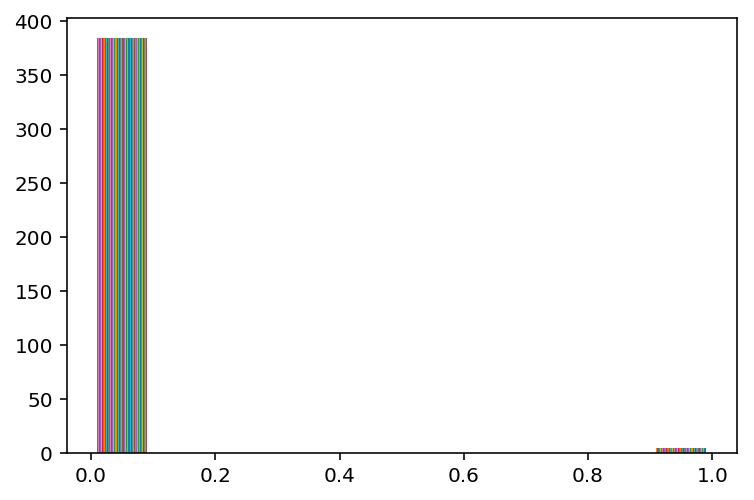

In [136]:
import matplotlib.pyplot as plt
plt.hist(pd.DataFrame(prediction).values.tolist())
plt.show()

Remove students not pairs, and test on them after training, remove k courses, see which ones pop up. Test on other domains. Try with all data. Compute f1. Plot precision and recall. Papers boi faltings on top k recommendations. Co enrollment matrix, weight probabilities of output by the student's chance of taking a course (obligatory). 

### Done
- All data gives really bad results (discrimination by section)
- Results are different from one domain to another (BEFORE WEIGHING OUT THE OBLIGATORY COURSES, or courses that are bloat (laboratories etc..., case by case basis ?)
- Computing the f1 score, prec and recall by row and average out
- [They talk a bit about top-N recommendation in this paper (Boi)](http://delivery.acm.org/10.1145/2810000/2800184/p179-maksai.pdf?ip=128.179.189.64&id=2800184&acc=ACTIVE%20SERVICE&key=FC66C24E42F07228%2E7E17DDD1CCA0F75B%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&CFID=1003867347&CFTOKEN=59100520&__acm__=1510214008_777b3b2b2f3763bb6c7aa57bcdcdf49a)

### Questions
- If we decide on keeping top-K recommendation metric, how would we deal with the fact that maybe there are clusters where the best K is 3, but others it will be 6 ?
- WTF: dropout was 0.50, now 0.998, way better results, higher dropout means less overfitting, so wtf ?
- Should weigh out the courses how ? In neural network or in ratings ?
- Are we sure on how to compute prec, rec, f1 ? For top-N rec sys, saw this:<br>The concept of ‘hit set’ is considered, containing only the recommended (top-N) items that are also in the test set.

    $recall = \frac{|hitset|}{|testset|}$
    <br>$precision = \frac{|hitset|}{N}$


### To do
- Move to the new data
- Take into account the study plan to compute percentage course taken (way of weighing)
- New precision and recall by user, and take average
- Pick k out of n for blocks, split options and obligatory recommendations
- Try on like 5 sections with same parameters if still good results
- Talk with Francisco about co enrolment matrix

In [155]:
print(courses_matrix.sum().sum())
baseline = 0.5
pred = prediction.copy()
pred[pred < baseline] = 0
pred[pred >= baseline] = 1
pred = pd.DataFrame(pred)
train_x_df = pd.DataFrame(train_x)
test_x_df = pd.DataFrame(test_x)

12048
2352


In [ ]:
flatten = courses_matrix.unstack().reset_index()
flatten = flatten.rename(columns={0:"Taken"})
random_user = flatten[(flatten.Taken == 1) & (flatten.PersonID == 974912207)]
random_user_id = courses_matrix.index.get_loc(key=974912207)
random_user_predictions = pred[random_user_id, -15:]
predicted_courses = [ courses_matrix.columns[i] for i in random_user_predictions ]

# Remove courses that were not given in the last year
last_year_courses = list(registrations.xs('2015-2016', level='YearName').index)
predicted_courses = [c for c in predicted_courses if c in last_year_courses]

print("The random user picked the following courses: \n{} \nHence we propose the following: {}"
     .format(random_user.SubjectName, predicted_courses[::-1] ))

In [ ]:
# Trying the Netflixprize solutions

In [ ]:
# Find other ones

In [ ]:
# Feature Engineering